In [1]:
# Standard imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

# Hugging Face Hub import

# Diffusers-specific imports
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Custom modules
from models import UNETLatentEdgePredictor, SketchSimplificationNetwork
from pipeline import SketchGuidedText2Image


c:\Users\zaccu\OneDrive\Documents\GitHub\U-SketchPlus\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# Configure and load sketch simplification network 

sketch_simplifier = SketchSimplificationNetwork().to(device)
sketch_simplifier.load_state_dict(torch.load("models-checkpoints/model_gan.pth"))

sketch_simplifier.eval()
sketch_simplifier.requires_grad_(False)

C:\Users\zaccu\AppData\Local\Temp\ipykernel_14848\1103916148.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sketch_simplifier.load_state_dict(torch.load("models-checkpo

SketchSimplificationNetwork(
  (0): Conv2d(1, 48, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU()
  (18): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (19): ReLU()
  (20): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [4]:
# Load Stable Diffusion Pipeline
stable_diffusion_1_5 = "benjamin-paine/stable-diffusion-v1-5"

In [5]:
stable_diffusion=StableDiffusionPipeline.from_pretrained(
    stable_diffusion_1_5,
    torch_dtype=torch.float16,
    safety_checker=None  # Skip the safety checker if it's not required
)
vae = stable_diffusion.vae.to(device)
unet = stable_diffusion.unet.to(device)
tokenizer = stable_diffusion.tokenizer
text_encoder = stable_diffusion.text_encoder.to(device) 

vae.eval()
unet.eval()
text_encoder.eval()

text_encoder.requires_grad_(False)
unet.requires_grad_(False)

Loading pipeline components...:  83%|████████▎ | 5/6 [00:08<00:01,  1.39s/it]c:\Users\zaccu\OneDrive\Documents\GitHub\U-SketchPlus\.venv\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing it

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [6]:
# Load U-Net latent edge predictor
checkpoint = torch.load("models-checkpoints/unet_latent_edge_predictor_checkpoint.pt",map_location=torch.device('cpu'))

LEP_UNET = UNETLatentEdgePredictor(9320, 4, 9).to(device)
LEP_UNET.load_state_dict(checkpoint["model_state_dict"])

LEP_UNET.eval()
LEP_UNET.requires_grad_(False)

C:\Users\zaccu\AppData\Local\Temp\ipykernel_14848\323835721.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("models-checkpoints/unet_latent_edge_

UNETLatentEdgePredictor(
  (e1): encoder_block(
    (conv): convolutional_block(
      (conv1): Conv2d(9320, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): convolutional_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (

In [7]:
import numpy 
# Set Scheduler
noise_scheduler = DDIMScheduler(
        beta_start = 0.00085,
        beta_end = 0.012,
        beta_schedule = "scaled_linear",
        num_train_timesteps = 1000,
        clip_sample = False,
    )

In [9]:
# Initialize Text-guided Text-to-Image synthesis pipeline

pipeline = SketchGuidedText2Image(stable_diffusion_pipeline = stable_diffusion, 
                                  unet = unet, vae = vae, 
                                  text_encoder = text_encoder, 
                                  lep_unet = LEP_UNET, scheduler = noise_scheduler, 
                                  tokenizer = tokenizer,
                                  sketch_simplifier = sketch_simplifier,
                                  device = device)

In [10]:
# Open the file and read its contents into a list
with open('objectstotest.txt', 'r') as file:
    lines = file.readlines()

# Remove newline characters
lines = [line.strip() for line in lines]
lines=[line.lower() for line in lines]



In [14]:
import os

# Path to the folder containing the sketches
base_path = os.path.normpath("./256x256/sketch/tx_000000000000")
for i in lines:
    newpath= os.path.join(base_path,i)
    print(newpath)
    # Check if the folder for the object exists
    if os.path.exists(newpath):
        # Sort the sketches to ensure consistency
        # Get the list of sketches in the folder
        sketches = os.listdir(newpath)
        sketches.sort()
        
        # Access the first sketch
        if sketches:
            first_sketch = sketches[0]
            sketch_path = os.path.join(newpath, first_sketch)
            print(f"First sketch for {i}: {sketch_path}")
            
            #Genearte Image
            edge_maps = [Image.open(sketch_path)]
            seed = 1000
            inverse_diffusion = pipeline.Inference(
            prompt=[i],
            num_images_per_prompt=1,
            edge_maps=edge_maps,
            negative_prompt=None,
            num_inference_timesteps=50,
            classifier_guidance_strength=8,
            sketch_guidance_strength=1.6,
            seed=seed,
            simplify_edge_maps=False,
            guidance_steps_perc=0.5,
            )
        for edge_map, image in zip(edge_maps, inverse_diffusion["generated_image"]):
            try:
                output_base_path = os.path.normpath("./non_edge_map_generated_images")
                obj_output_path = os.path.join(output_base_path, i)
                
                # Create the folder if it doesn't exist
                os.makedirs(obj_output_path, exist_ok=True)
                
                # Save the generated image
                output_image_path = os.path.join(obj_output_path, "sketch_image.png")
                edge_map.save(output_image_path)
                output_image_path = os.path.join(obj_output_path, "generated_image.png")
                image.save(output_image_path)
                
                
            except Exception as e:
                 print(f"Error processing sketch for {i}: {e}")    


    
        else:
            print(f"No sketches found for {i}.")
    else:
        print(f"Folder not found for {i}.")
        

256x256\sketch\tx_000000000000\axe
First sketch for axe: 256x256\sketch\tx_000000000000\axe\n02764044_10196-1.png


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


No sketches found for axe.
256x256\sketch\tx_000000000000\ape
First sketch for ape: 256x256\sketch\tx_000000000000\ape\n02470325_11241-1.png


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


No sketches found for ape.
256x256\sketch\tx_000000000000\bat
First sketch for bat: 256x256\sketch\tx_000000000000\bat\n02139199_10196-1.png


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


No sketches found for bat.
256x256\sketch\tx_000000000000\bench
First sketch for bench: 256x256\sketch\tx_000000000000\bench\n02828884_1011-1.png


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


No sketches found for bench.
256x256\sketch\tx_000000000000\chair
First sketch for chair: 256x256\sketch\tx_000000000000\chair\n02738535_10219-1.png


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


No sketches found for chair.
256x256\sketch\tx_000000000000\clock
Folder not found for clock.
256x256\sketch\tx_000000000000\cabin
First sketch for cabin: 256x256\sketch\tx_000000000000\cabin\n02932400_10327-1.png


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


No sketches found for cabin.
256x256\sketch\tx_000000000000\couch
First sketch for couch: 256x256\sketch\tx_000000000000\couch\n04256520_10347-1.png


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


No sketches found for couch.
256x256\sketch\tx_000000000000\door
First sketch for door: 256x256\sketch\tx_000000000000\door\n03222176_10952-1.png


100%|██████████| 50/50 [00:46<00:00,  1.06it/s]


No sketches found for door.
256x256\sketch\tx_000000000000\cup
First sketch for cup: 256x256\sketch\tx_000000000000\cup\n03063073_10319-1.png


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


No sketches found for cup.
256x256\sketch\tx_000000000000\guitar
First sketch for guitar: 256x256\sketch\tx_000000000000\guitar\n02676566_11377-1.png


100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


No sketches found for guitar.
256x256\sketch\tx_000000000000\hat
First sketch for hat: 256x256\sketch\tx_000000000000\hat\n02859184_11923-1.png


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


No sketches found for hat.
256x256\sketch\tx_000000000000\hourglass
First sketch for hourglass: 256x256\sketch\tx_000000000000\hourglass\n03544143_10005-1.png


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


No sketches found for hourglass.
256x256\sketch\tx_000000000000\knife
First sketch for knife: 256x256\sketch\tx_000000000000\knife\n02973904_2077-1.png


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


No sketches found for knife.
256x256\sketch\tx_000000000000\piano
First sketch for piano: 256x256\sketch\tx_000000000000\piano\n03452741_10036-1.png


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


No sketches found for piano.
256x256\sketch\tx_000000000000\pen
Folder not found for pen.
256x256\sketch\tx_000000000000\rifle
First sketch for rifle: 256x256\sketch\tx_000000000000\rifle\n02749479_1437-1.png


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


No sketches found for rifle.
256x256\sketch\tx_000000000000\sailboat
First sketch for sailboat: 256x256\sketch\tx_000000000000\sailboat\n04128499_10000-1.png


100%|██████████| 50/50 [00:41<00:00,  1.19it/s]


No sketches found for sailboat.
256x256\sketch\tx_000000000000\skyscraper
First sketch for skyscraper: 256x256\sketch\tx_000000000000\skyscraper\n04233124_10156-1.png


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


No sketches found for skyscraper.
256x256\sketch\tx_000000000000\sword
First sketch for sword: 256x256\sketch\tx_000000000000\sword\n03039493_2187-1.png


100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


No sketches found for sword.
256x256\sketch\tx_000000000000\teddy_bear
First sketch for teddy_bear: 256x256\sketch\tx_000000000000\teddy_bear\n04399382_1016-1.png


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


No sketches found for teddy_bear.
256x256\sketch\tx_000000000000\wine_bottle
First sketch for wine_bottle: 256x256\sketch\tx_000000000000\wine_bottle\n04591713_1035-1.png


100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


No sketches found for wine_bottle.
256x256\sketch\tx_000000000000\airplane
First sketch for airplane: 256x256\sketch\tx_000000000000\airplane\n02691156_10151-1.png


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


No sketches found for airplane.
256x256\sketch\tx_000000000000\banana
First sketch for banana: 256x256\sketch\tx_000000000000\banana\n07753592_10196-1.png


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


No sketches found for banana.
256x256\sketch\tx_000000000000\ball
Folder not found for ball.
256x256\sketch\tx_000000000000\broccoli
Folder not found for broccoli.
256x256\sketch\tx_000000000000\car
Folder not found for car.
256x256\sketch\tx_000000000000\cannon
First sketch for cannon: 256x256\sketch\tx_000000000000\cannon\n02950826_1005-1.png


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


No sketches found for cannon.
256x256\sketch\tx_000000000000\cow
First sketch for cow: 256x256\sketch\tx_000000000000\cow\n01887787_1-1.png


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


No sketches found for cow.
256x256\sketch\tx_000000000000\crown
Folder not found for crown.
256x256\sketch\tx_000000000000\donut
Folder not found for donut.
256x256\sketch\tx_000000000000\house
Folder not found for house.
256x256\sketch\tx_000000000000\rocket
First sketch for rocket: 256x256\sketch\tx_000000000000\rocket\n03773504_10236-1.png


100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


No sketches found for rocket.


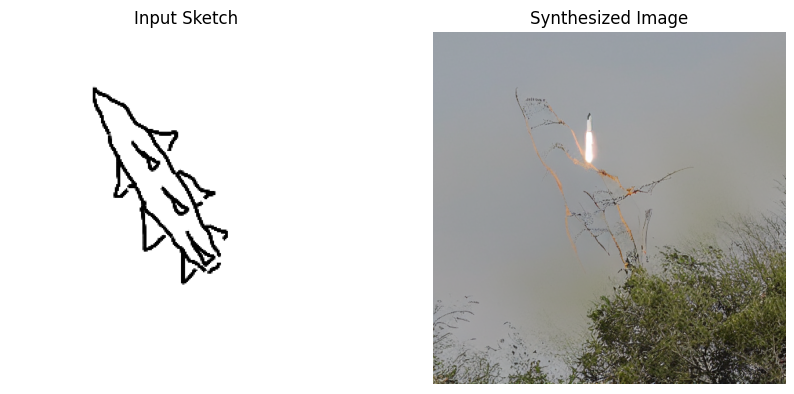

In [12]:
for edge_map, image in zip(edge_maps, inverse_diffusion["generated_image"]):
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    axs[0].imshow(edge_map)
    axs[1].imshow(image)
    axs[0].axis("off")
    axs[1].axis("off")
    axs[0].set_title("Input Sketch")
    axs[1].set_title("Synthesized Image")